In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [11]:
# Input file paths
biomass_paths = {
    "consumption": "./Outputs/Biomass/total_biomass_consumption_per_cell.csv",
    "production": "./Input_Data/Biomass/Total_Annual_NPP_Per_cell.csv",
    "storage": "./Outputs/Biomass/total_biomass_stor_per_cell.csv",
    "boundary": "./Input_Data/maps/mask/Otta_mask.shp",
    "annual_balance": "./Outputs/Biomass/Annual_Biomass_Balance.csv"
}

energy_paths = {
    "consumption": "./Outputs/Energy/Mean_Consumption_Per_Cell.csv",
    "production": "./Outputs/Energy/mean_annual_production_per_cell.csv",
    "storage": "./Outputs/Energy/Mean_Storage_Per_Cell.csv",
    "boundary": "./Input_Data/maps/mask/Otta_mask.shp",
    "annual_balance": "./Outputs/Energy/Annual_Balance.csv"
}

water_paths = {
    "consumption": "./Outputs/Water/total_consumption_per_cell.csv",
    "production": "./Input_Data/Meteo/Annual_precip_per_cell.csv",
    "storage": "./Outputs/Water/Total_Storage_per_cell.csv",
    "boundary": "./Input_Data/maps/mask/Otta_mask.shp",
    "annual_balance": "./Outputs/Water/Annual_Water_Balance.csv"
}

# Function to add grid overlay
def add_grid_overlay(ax, grid_cells, cell_size):
    for _, row in grid_cells.iterrows():
        rect = patches.Rectangle(
            (row["X"] - cell_size / 2, row["Y"] - cell_size / 2),
            cell_size, cell_size,
            linewidth=0.1, edgecolor='gray', facecolor='none'
        )
        ax.add_patch(rect)

# Function to format colorbar ticks
def format_as_power_cleaner(x, _):
    if x < 10:
        return f"{int(x)}"  # Show integers for small values
    else:
        exponent = int(np.log10(x))
        return f"$10^{{{exponent}}}$"

# Generate grid geometry
extent = (95000, 6837000, 213000, 6917000)
cell_size = 1000
n_cols = int((extent[2] - extent[0]) / cell_size)
n_rows = int((extent[3] - extent[1]) / cell_size)
grid_x, grid_y = np.meshgrid(
    np.linspace(extent[0] + cell_size / 2, extent[2] - cell_size / 2, n_cols),
    np.linspace(extent[3] - cell_size / 2, extent[1] + cell_size / 2, n_rows),
)
grid_cells = pd.DataFrame({
    "Cell_ID": range(1, n_cols * n_rows + 1),
    "X": grid_x.flatten(),
    "Y": grid_y.flatten(),
})

# Load data into dictionaries
biomass_data = {
    "consumption": pd.read_csv(biomass_paths["consumption"], usecols=["Cell_ID", "Total_Mean_Consumption"]).merge(grid_cells, on="Cell_ID"),
    "production": pd.read_csv(biomass_paths["production"], usecols=["Cell_ID", "Mean_Annual"]).merge(grid_cells, on="Cell_ID"),
    "storage": pd.read_csv(biomass_paths["storage"], usecols=["Cell_ID", "Total_Mean_Storage"]).merge(grid_cells, on="Cell_ID"),
    "boundary": gpd.read_file(biomass_paths["boundary"]).to_crs("EPSG:25833"),
    "annual_balance": pd.read_csv(biomass_paths["annual_balance"])
}

energy_data = {
    "consumption": pd.read_csv(energy_paths["consumption"], usecols=["Cell_ID", "Mean_Consumption"]).merge(grid_cells, on="Cell_ID"),
    "production": pd.read_csv(energy_paths["production"], usecols=["Cell_ID", "Mean_Annual_Production"]).merge(grid_cells, on="Cell_ID"),
    "storage": pd.read_csv(energy_paths["storage"], usecols=["Cell_ID", "Total_Storage"]).merge(grid_cells, on="Cell_ID"),
    "boundary": gpd.read_file(energy_paths["boundary"]).to_crs("EPSG:25833"),
    "annual_balance": pd.read_csv(energy_paths["annual_balance"])
}

water_data = {
    "consumption": pd.read_csv(water_paths["consumption"], usecols=["Cell_ID", "Total_Mean_Consumption"]).merge(grid_cells, on="Cell_ID"),
    "production": pd.read_csv(water_paths["production"], usecols=["Cell_ID", "Mean_Annual"]).merge(grid_cells, on="Cell_ID"),
    "storage": pd.read_csv(water_paths["storage"], usecols=["Cell_ID", "Total_Storage"]).merge(grid_cells, on="Cell_ID"),
    "boundary": gpd.read_file(water_paths["boundary"]).to_crs("EPSG:25833"),
    "annual_balance": pd.read_csv(water_paths["annual_balance"])
}

# Organize data grids
data_grids = {
    "waterscape": [
        (water_data["production"].query("Mean_Annual > 0"), "Mean_Annual"),
        (water_data["consumption"].query("Total_Mean_Consumption > 0"), "Total_Mean_Consumption"),
        (water_data["storage"].query("Total_Storage > 0"), "Total_Storage")
    ],
    "energyscape": [
        (energy_data["production"].query("Mean_Annual_Production > 0"), "Mean_Annual_Production"),
        (energy_data["consumption"].query("Mean_Consumption > 0"), "Mean_Consumption"),
        (energy_data["storage"].query("Total_Storage > 0"), "Total_Storage")
    ],
    "bioscape": [
        (biomass_data["production"].query("Mean_Annual > 0"), "Mean_Annual"),
        (biomass_data["consumption"].query("Total_Mean_Consumption > 0"), "Total_Mean_Consumption"),
        (biomass_data["storage"].query("Total_Mean_Storage > 0"), "Total_Mean_Storage")
    ]
}

# Define titles, labels, and legends
titles = {
    "waterscape": ["Precipitation", "Water Consumption", "Water Storage", "Annual Balance"],
    "energyscape": ["Energy Production", "Energy Consumption", "Energy Storage", "Annual Balance"],
    "bioscape": ["Biomass Production", "Biomass Consumption", "Biomass Storage", "Annual Balance"]
}
y_axis_labels = {
    "energyscape": "Energy (GWh)",
    "waterscape": "Water (m$^3$)",
    "bioscape": "Biomass (tons)"
}
legend_titles = {
    "energyscape": "Energy",
    "waterscape": "Water",
    "bioscape": "Biomass"
}

panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']

# Plot settings
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(50, 45), dpi=300, gridspec_kw={'hspace': 0.2, 'wspace': 0.2})

# Iterate over rows and columns for maps
for idx, (landscape, data) in enumerate(data_grids.items()):
    for row_idx, (data_grid, col) in enumerate(data):
        ax = axes[row_idx, idx]

        # Normalize scale
        norm = LogNorm(vmin=max(data_grid[col].replace(0, np.nan).min(), 1), vmax=data_grid[col].quantile(0.99))

        # Scatter plot
        sc = ax.scatter(data_grid["X"], data_grid["Y"], c=data_grid[col], cmap='YlGnBu', s=20, marker='s', norm=norm)

        # Overlay boundary
        boundary = biomass_data["boundary"] if landscape == "bioscape" else (
            energy_data["boundary"] if landscape == "energyscape" else water_data["boundary"]
        )
        boundary.plot(ax=ax, edgecolor="black", facecolor="none")

        # Add grid overlay
        add_grid_overlay(ax, data_grid, cell_size)

        # Set titles and labels
        ax.set_title(titles[landscape][row_idx], fontsize=32, fontweight='bold')
        ax.set_xlabel("Easting (m)", fontsize=20)
        ax.set_ylabel("Northing (m)", fontsize=20)
        ax.tick_params(axis='both', labelsize=20)

        # Panel label
        ax.text(-0.1, 1.05, panel_labels[idx * 3 + row_idx], transform=ax.transAxes, fontsize=40, fontweight='bold')

        # Add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = fig.colorbar(sc, cax=cax)
        cbar.set_label(y_axis_labels[landscape], fontsize=28)
        cbar.ax.tick_params(labelsize=20)
        cbar.formatter = plt.FuncFormatter(format_as_power_cleaner)
        cbar.update_ticks()

# Annual balance plots
for col_idx, landscape in enumerate(["waterscape", "energyscape", "bioscape"]):
    ax = axes[3, col_idx]
    annual_balance = water_data["annual_balance"] if landscape == "waterscape" else (
        energy_data["annual_balance"] if landscape == "energyscape" else biomass_data["annual_balance"]
    )

    # Bar chart
    years = annual_balance["Year"]
    data = annual_balance.drop(columns="Year")
    bottom = np.zeros(len(years))
    for col in data.columns:
        ax.bar(years, data[col], bottom=bottom, label=col, color=column_color_map.get(col, "#333333"))
        bottom += data[col]

    # Set title and labels
    ax.set_title(titles[landscape][3], fontsize=32, fontweight='bold')
    ax.set_xlabel("Year", fontsize=28)
    ax.set_ylabel(y_axis_labels[landscape], fontsize=28)
    ax.set_yscale('log')
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.tick_params(axis='both', labelsize=20)
    #legend = plt.legend(loc="upper right", edgecolor="black")
    #legend.get_frame().set_alpha(None)
    #legend.get_frame().set_facecolor((0, 0, 1, 0.1))
    ax.legend(loc="upper left", title=legend_titles[landscape], fontsize=18, 
              framealpha=0.8, title_fontsize=20, frameon=True)

# Adjust layout and save
plt.tight_layout(pad=2)
plt.savefig("./Results/Final_Figure.jpg", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\zvirk20\AppData\Local\Temp\ipykernel_148324\3845302105.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


#### For Word Compatibility

C:\Users\zvirk20\AppData\Local\Temp\ipykernel_148324\4148821986.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


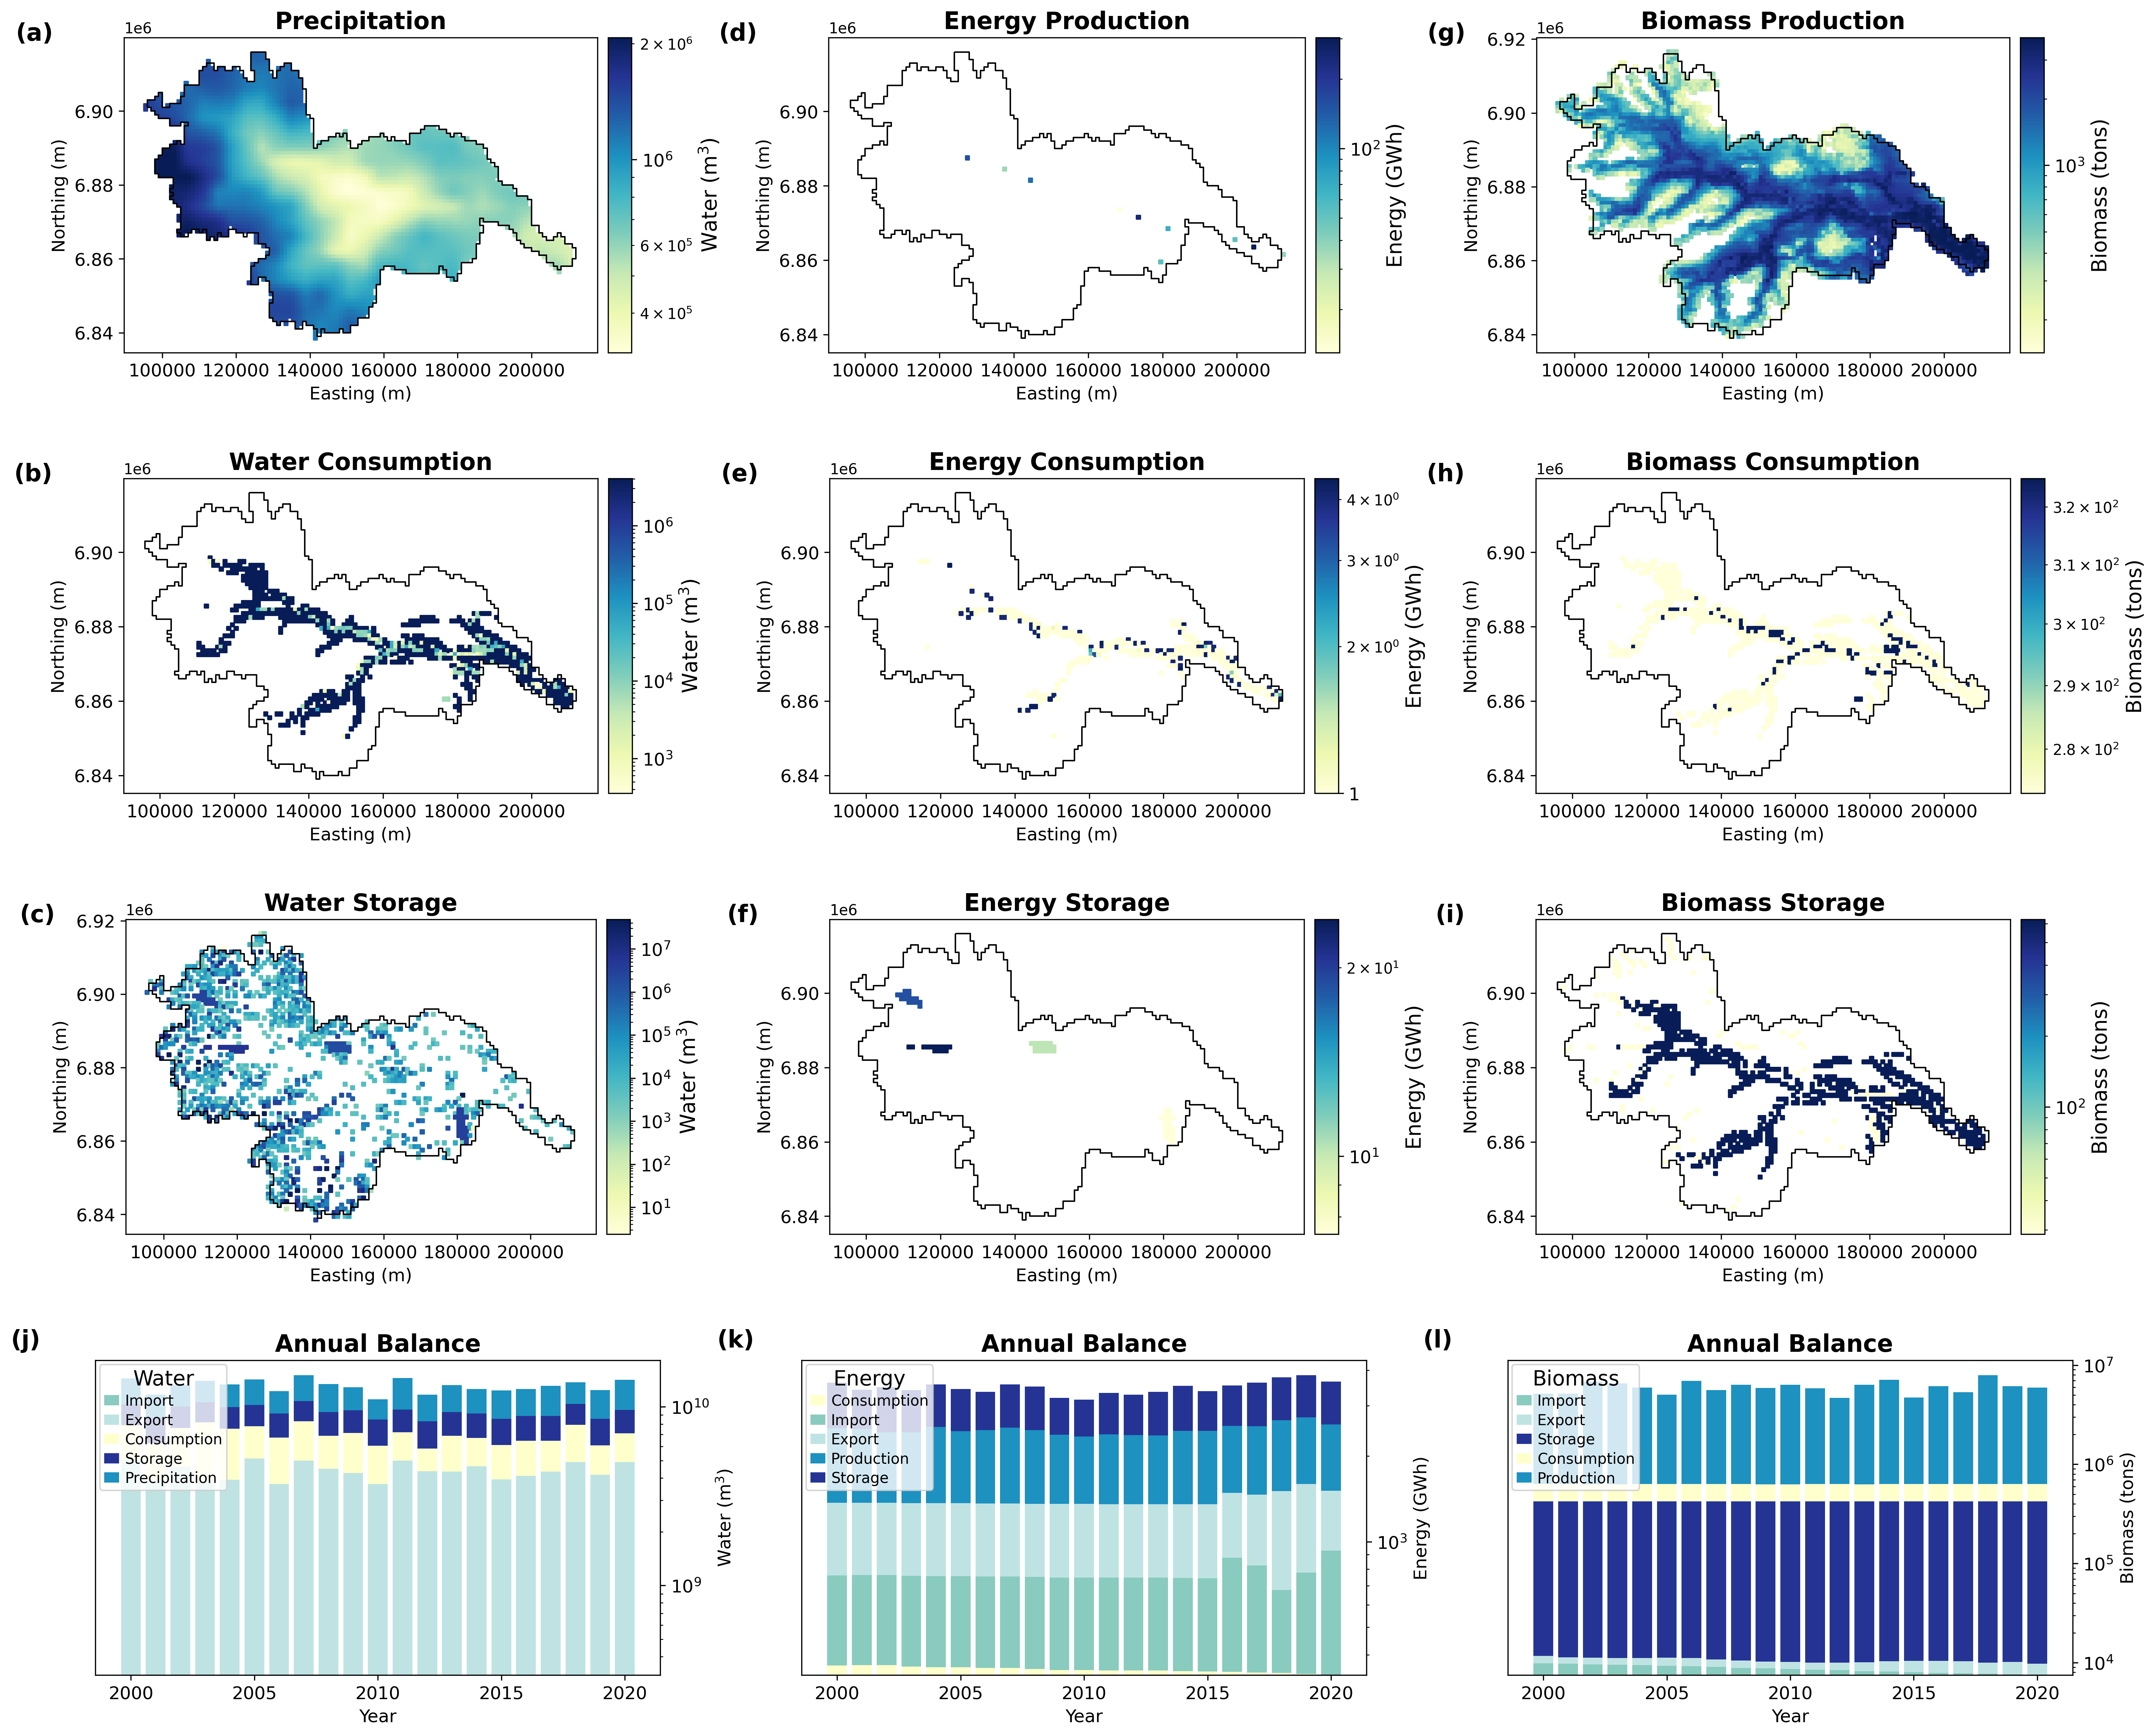

In [26]:
# Plot settings
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(24, 20), dpi=300,
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.25})

title_fontsize = 16
axis_label_fontsize = 12
tick_label_fontsize = 12
panel_label_fontsize = 16
cbar_label_fontsize = 14
legend_fontsize = 10
legend_title_fontsize =14 
scatter_size = 6


# Iterate over rows and columns for maps
for idx, (landscape, data) in enumerate(data_grids.items()):
    for row_idx, (data_grid, col) in enumerate(data):
        ax = axes[row_idx, idx]

        # Normalize scale
        norm = LogNorm(vmin=max(data_grid[col].replace(0, np.nan).min(), 1), 
                       vmax=data_grid[col].quantile(0.99))

        # Scatter plot
        sc = ax.scatter(
            data_grid["X"], data_grid["Y"], 
            c=data_grid[col], cmap='YlGnBu', s=scatter_size, marker='s', norm=norm
        )

        # Overlay boundary
        boundary = (biomass_data["boundary"] if landscape == "bioscape" else
                    energy_data["boundary"] if landscape == "energyscape" else 
                    water_data["boundary"])
        boundary.plot(ax=ax, edgecolor="black", facecolor="none")

        # Add grid overlay
        #add_grid_overlay(ax, data_grid, cell_size)

        # Set titles and labels
        ax.set_title(titles[landscape][row_idx], fontsize=title_fontsize, fontweight='bold')
        ax.set_xlabel("Easting (m)", fontsize=axis_label_fontsize)
        ax.set_ylabel("Northing (m)", fontsize=axis_label_fontsize)
        ax.tick_params(axis='both', labelsize=tick_label_fontsize)

        # Panel label
        ax.text(-0.15, 1.05, panel_labels[idx * 3 + row_idx], transform=ax.transAxes, 
                fontsize=panel_label_fontsize, fontweight='bold', va='top', ha='right')

        # Add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = fig.colorbar(sc, cax=cax)
        cbar.set_label(y_axis_labels[landscape], fontsize=cbar_label_fontsize)
        cbar.ax.tick_params(labelsize=tick_label_fontsize)
        cbar.formatter = plt.FuncFormatter(format_as_power_cleaner)
        cbar.update_ticks()

# Annual balance plots
for col_idx, landscape in enumerate(["waterscape", "energyscape", "bioscape"]):
    ax = axes[3, col_idx]
    annual_balance = (water_data["annual_balance"] if landscape == "waterscape" else
                      energy_data["annual_balance"] if landscape == "energyscape" else
                      biomass_data["annual_balance"])

    # Bar chart
    years = annual_balance["Year"]
    data = annual_balance.drop(columns="Year")
    bottom = np.zeros(len(years))
    for col in data.columns:
        ax.bar(years, data[col], bottom=bottom, label=col, color=column_color_map.get(col, "#333333"))
        bottom += data[col]

    # Set title and labels
    ax.set_title(titles[landscape][3], fontsize=title_fontsize, fontweight='bold')
    ax.set_xlabel("Year", fontsize=axis_label_fontsize)
    ax.set_ylabel(y_axis_labels[landscape], fontsize=axis_label_fontsize)
    ax.set_yscale('log')
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.tick_params(axis='both', labelsize=tick_label_fontsize)
    ax.legend(loc="upper left", title=legend_titles[landscape],
              fontsize=legend_fontsize, 
              title_fontsize=legend_title_fontsize, 
              labelspacing=0.3,       # Reduce vertical space between entries
              handlelength=1.0,       # Shorten the legend handles
              handletextpad=0.4,      # Bring text closer to the handles
              borderpad=0.3,          # Less space around the inside edge of the legend box
              borderaxespad=0.3,
              framealpha=0.8, 
              frameon=True)
    label_index = 9 + col_idx
    ax.text(-0.15, 1.10, panel_labels[label_index],
            transform=ax.transAxes, fontsize=16, fontweight='bold',
            va='top', ha='left', color='black')

plt.tight_layout(pad=2)
plt.savefig("./Results/Final_Figure_Word.pdf", dpi=300, bbox_inches="tight")
plt.show()
